In [1]:
LOAD_FROM_CACHE = False

In [2]:
from transformers import GPT2Tokenizer
from experiment import Intervention, Model
from attention_utils import perform_interventions, report_intervention, report_interventions_summary_by_head, report_interventions_summary_by_layer
import pandas as pd
import json
import os

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


In [3]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = Model(output_attentions=True)

In [4]:
# Test experiment
interventions = [
	Intervention(
        tokenizer,
        "The doctor asked the nurse a question. {}",
        ["He", "She"],
        ["asked", "answered"]),
	Intervention(
        tokenizer,
        "The doctor asked the nurse a question. {}",
        ["He", "She"],
        ["requested", "responded"]),
	Intervention(
        tokenizer,
        "The man felt sorry about what he said to the woman. {}",
        ["He", "She"],
        ["apologized", "forgave"]),
	Intervention(
        tokenizer,
        "The nurse notified the patient that {}",
        ["her", "his"],
        ["shift", "blood"])
]

# dirname = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__)))
path = 'test_attn_int.json'
if not LOAD_FROM_CACHE:
	results = perform_interventions(interventions, model)
	with open(path, 'w') as f:
		json.dump(results, f)
with open(path) as f:
	results = json.load(f)


  0%|          | 0/4 [00:00<?, ?it/s]/Users/jvig/repos/lm-intervention/experiment.py:443: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tok_ids).unsqueeze(0)
100%|██████████| 4/4 [02:13<00:00, 33.28s/it]


x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
c1: asked
c2: answered

p(c2|x) / p(c1|x) = 0.06125
p(c2|x') / p(c1|x') = 0.37261

TOTAL Effect: (p(c2|x') / p(c1|x')) / (p(c2|x) / p(c1|x)) - 1 = 5.084


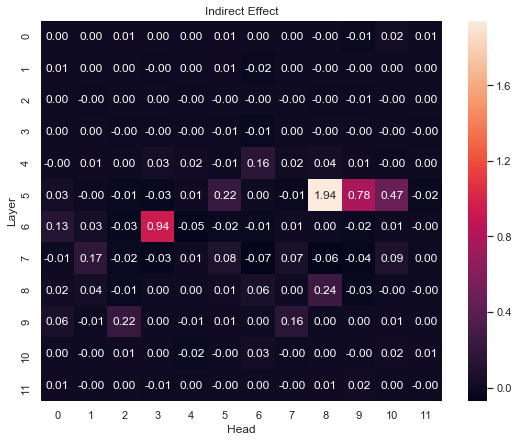

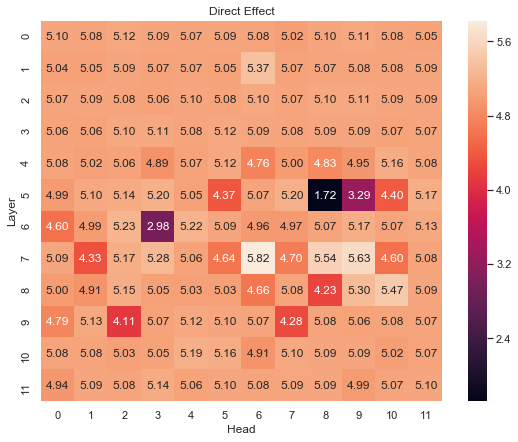

In [5]:
report_intervention(results[0])

x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
c1: requested
c2: responded

p(c2|x) / p(c1|x) = 5.60554
p(c2|x') / p(c1|x') = 48.40229

TOTAL Effect: (p(c2|x') / p(c1|x')) / (p(c2|x) / p(c1|x)) - 1 = 7.635


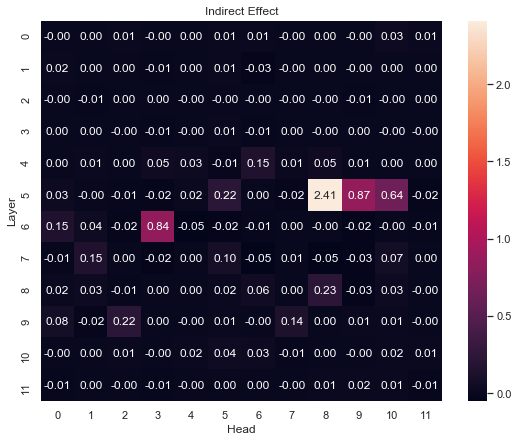

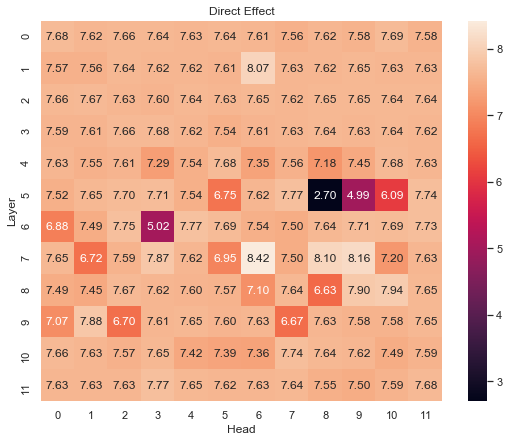

In [6]:
report_intervention(results[1])

x : The man felt sorry about what he said to the woman. He
x': The man felt sorry about what he said to the woman. She
c1: apologized
c2: forg ave

p(c2|x) / p(c1|x) = 1.22402
p(c2|x') / p(c1|x') = 3.17623

TOTAL Effect: (p(c2|x') / p(c1|x')) / (p(c2|x) / p(c1|x)) - 1 = 1.595


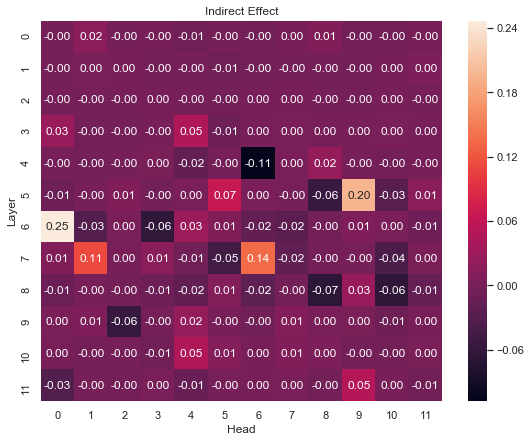

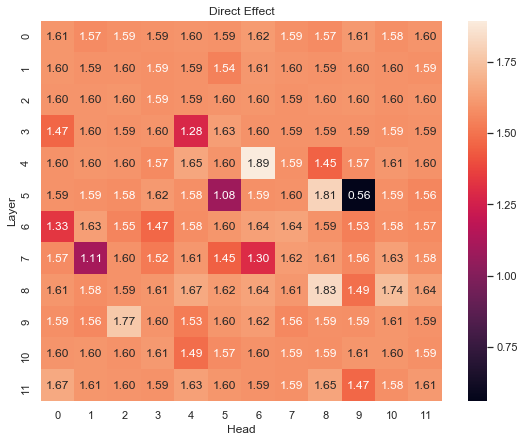

In [7]:
report_intervention(results[2])

x : The nurse notified the patient that her
x': The nurse notified the patient that his
c1: shift
c2: blood

p(c2|x) / p(c1|x) = 41.54527
p(c2|x') / p(c1|x') = 102.70796

TOTAL Effect: (p(c2|x') / p(c1|x')) / (p(c2|x) / p(c1|x)) - 1 = 1.472


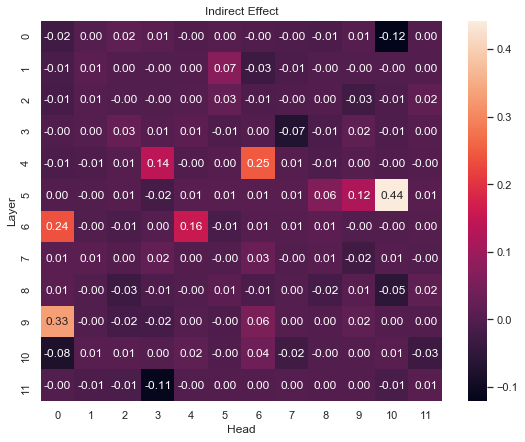

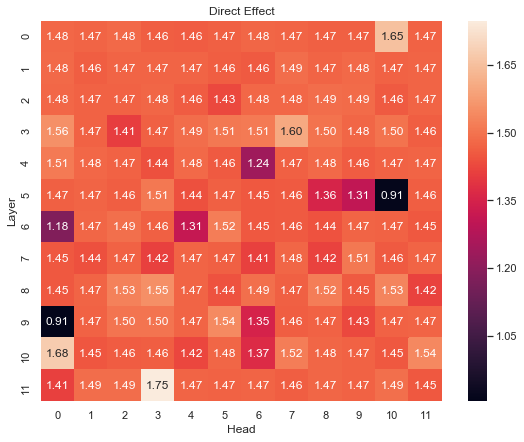

In [8]:
report_intervention(results[3])

*** SUMMARY BY HEAD ***
Num interventions: 4
Mean total effect: 3.95

INDIRECT Effect (mean = 0.02425430529705687)
Top 10 heads:
   5 8: 1.089827038347721 (p=0.0000)
   5 9: 0.49110218696296215 (p=0.0000)
   6 3: 0.43204583798069507 (p=0.0000)
   5 10: 0.3836207785643637 (p=0.0000)
   6 0: 0.1915343776345253 (p=0.0169)
   5 5: 0.12752953334711492 (p=0.0949)
   9 0: 0.11988488805945963 (p=0.1126)
   7 1: 0.11240292503498495 (p=0.1314)
   4 6: 0.11201865412294865 (p=0.1329)
   8 8: 0.09752357983961701 (p=0.1765)

DIRECT Effect (mean = 3.8832578867052994)
Top 10 heads:
   5 8: 1.8957747220993042 (p=0.0602)
   5 9: 2.5371530055999756 (p=0.1466)
   6 3: 2.735113501548767 (p=0.1848)
   5 10: 3.248765528202057 (p=0.3102)
   7 1: 3.400213658809662 (p=0.3531)
   5 5: 3.4183193147182465 (p=0.3584)
   9 7: 3.4928603172302246 (p=0.3803)
   6 0: 3.499538838863373 (p=0.3823)
   9 2: 3.5203941464424133 (p=0.3885)
   8 8: 3.5515801906585693 (p=0.3978)


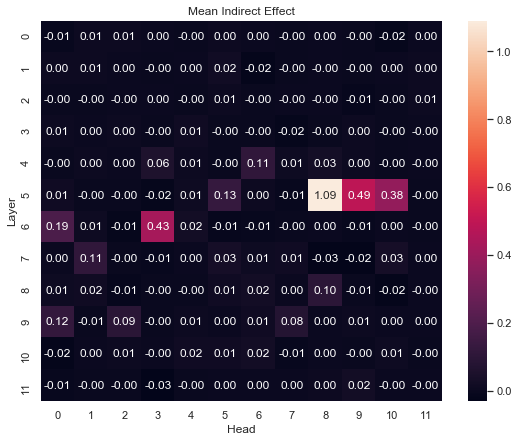

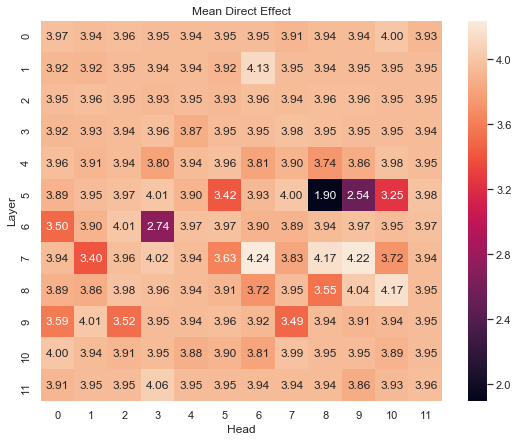

In [9]:
report_interventions_summary_by_head(results)

*** SUMMARY BY LAYER ***
Num interventions: 4
Mean total effect: 3.95


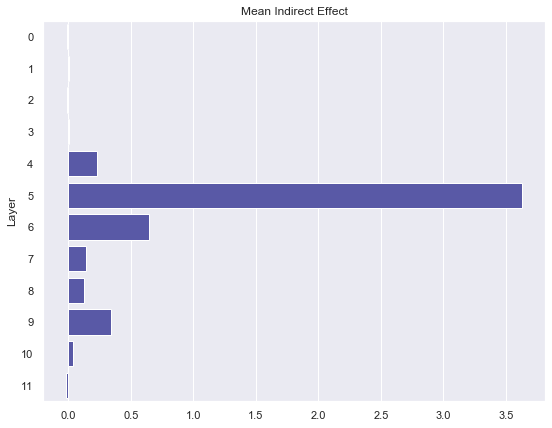

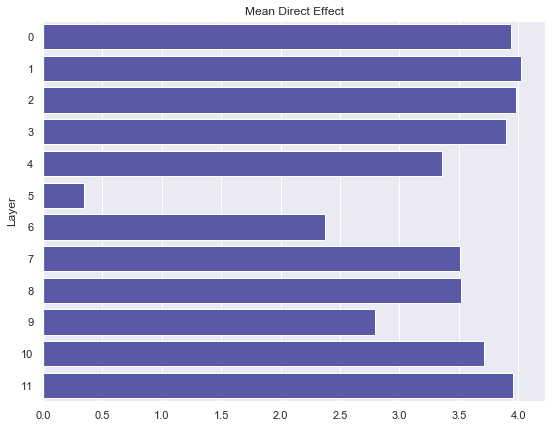

In [10]:
report_interventions_summary_by_layer(results)